# 2. 自然言語処理と単語の分散表現

この本では、自然言語処理として、（言葉の意味の最小単位である）単語の意味をコンピュータに理解させる方法として、以下の３つの方法を見ていく。

* シソーラスによる手法
* カウントベースによる手法
* 推論ベースの手法（word2vec) → ３章

## 2.2 シソーラス

シソーラスとは、基本的には類語辞書で、同義語や類義語が同じグループに分類される辞書で、以下の特徴を持つ。

* 人の手でメンテナンスされる辞書。
* 例えば、`car ` = `auto` `automobile` `machine` `motorcar` のよう同義語を得ることができる。
* 単語間で、「上位と下位」、「全体と部分」などの、関連性が定義されていることがある。例えば、carの場合

![relation](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/thesaurus.png)

このようにすべての単語に対して、類義語の集合を作り、それぞれの単語の関係をグラフで表現することで、単語間のつながりを定義できる。  
これは、コンピュータに単語の意味を（間接的にであれ）授けることができたと言える。

### 2.2.1 WordNet

自然言語処理の分野で、最も有名なシソーラスはWordNetであり、NLTKに入っている。  
http://www.nltk.org/howto/wordnet.html

ただの辞書なので動作は割愛。実際の動作は付録B参照。

### 2.2.2 シソーラスの問題点

人の手でメンテナンスされるもののため、以下の問題点が存在する。

* 時代の変化に対応するのが困難  
→ 言葉は時とともに変化する。
* 人の作業コストが高い
* 単語のニュアンスを表現できない  
→ ex. ヴィンテージとレトロ

## 2.3 カウントベースの手法


コーパス → 分布仮説からの共起行列 → コサイン類似度 → 相互情報量 → 次元削減という流れ。  
また１文からなる単純なテキスト → 実践的なコーパスという流れ。

### 2.3.1 コーパスの下準備

コーパスとは、自然言語処理の研究やアプリケーションのために目的をもって収集された大量のテキストデータ。  
以降は、まず`You say goodbye and I say hello.`という文を対象として、処理を行っていく。ここでは、下準備処理を行う。


In [1]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus) ## 単語IDのリスト  
print(word_to_id) ## 単語から単語IDへのディクショナリ 
print(id_to_word) ## 単語IDから単語へのディクショナリ

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 2.3.2 単語の分散表現

自然言語処理で、単語を（色のRGBのような）ベクトル表現で行うことができれば、定量化が簡単に行える。  
単語のベクトルを、単語の分散表現と呼ぶ。

### 2.3.3 分布仮説

自然言語処理の歴史において、単語をベクトルで表す研究は数多く行われてきた。そのほどんどすべてが、「単語の意味は、周囲の単語によって形成される」という、分布仮説に呼ばれるもの。  
つまり、単語の意味はその単語のコンテキスト（文脈）によって、単語の意味が形成されるということ。

ex.   
「I drink beer」「We drink wine」  
「I guzzle beer」「We　guzzle wine」  
guzzle: がぶがぶ飲む

この本では、以下のように定義している。

コンテキスト： ある中央の単語に対して、その周囲にある単語
ウィンドウサイズ： 周囲の単語をどれだけ含めるか

![context](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/context.png)

### 2.3.4 共起行列

カウントベースでは、周囲の単語をカウントすることで、ベクトルを表現する。  
具体的にはある単語に着目した場合、その周囲にどのような単語がどれだけ現れるのかをカウントし、それを集計する。


|  --| you | say | goodbye | and | i | hello | . |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| you | 0 | 1 | 0 | 0 | 0 | 0 | 0 |
| say | 1 | 0 | 1 | 0 | 1 | 1 | 0 |
| goodbye | 0 | 1 | 0 | 1 | 0 | 0 | 0 |
| and | 0 | 0 | 1 | 0 | 1 | 0 | 0 |
| i | 0 | 1 | 0 | 1 | 0 | 0 | 0 |
| hello | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
| . | 0 | 0| 0 | 0 | 0 | 1 | 0 |

上記の共起行列をプログラミングで自動で作成する関数を作成する。

In [2]:
import numpy as np

# vocab_size: 語彙数
def create_to_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus.size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix
        
C = create_to_matrix(corpus, len(word_to_id))

print(C)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 2.2.5 ベクトル間の類似度

単語のベクトル表現の類似度に関しては、コサイン類似度がよく用いられる。

![similarity](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/similarity.png)


In [3]:
import numpy as np

# eps : 0除算を避けるため
def cos_similarity(x,y,eps = 1e-8):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0,c1))

0.7071067811865475


## 2.4.1 相互情報量

前回の共起行列の要素は、２つの単語が共起した回数を表してる。  
しかし、この"生"の回数というのはあまり良い性質ではない。  
例えば、'the', 'a' などを考えるとわかりやすい。名詞と共起されやすい。

この問題を解決するために、相互情報量（Poinwise Mutual Infomation、以降PMI）と呼ばれる指標が使われる。  
以下の式で表される。

![pmi](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/pmi.png)

ここでP(x)はxが起こる確率、P(y)はyが起きる確率、P(x,y)はxとyが同時に起こる確率をあらわす。  
PMIが高いほど、関連性が高いことを示す。

PMIを式変形し、Nをコーパスに含まれる単語数、Cを単語の出現回数とすると、以下のように表せる。

![pmi-count](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/pmi-count.png)

PMIをそのまま使うと、log0 = -∞ に発散してしまうため、実践上では正の相互情報量（Positive PMI、以降PPMI）が使われる。

![ppmi](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/ppmi.png)

PPMIを実装すると以下のようになる。

In [7]:
import numpy as np

def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0) # 各列の和をとった行ベクトル
    total = C.shape[0] * C.shape[1] # 行列の要素数
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i,j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print("%.1f%% done" % 100*cnt/total)
    
    return M

W = ppmi(C)
np.set_printoptions(precision=3) # 有効桁数3桁表示
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


# 2.4.2 次元削減

上記のPPMI行列には大きな問題がある。それは、コーパスの語彙数が増えるにつれて、各単語のベクトルの次元数も増えていくという問題。
また、この行列の中身は０が多く、ベクトルのほとんどの要素が重要ではない、ことがわかる。

そこで、次元削減（dimensionality reduction) を行う。

次元削減とは直感的には以下のように、適切な軸に置き換える行為。

![dimension](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/dimension.png)

次元削減を行う方法として、ここでは特異値分解（Singular Value Decomposition）を行う。

![svd](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/svd.png)

任意の行列Xを、U,S,Vの３つの行列の積に分解する。
ここで、UとVは直行行列であり、Sは対角行列。

証明は以下参照。  
https://risalc.info/src/svd.html

SVDの性質として、Sは対角行列で、この対角成分には、「特異値」というものが大きい順に並んでいる。  
（特異値とは、簡単に言えば、「対応する軸」の重要度とみなすことができる）  
そこで、特異値が小さいものは重要度が低いので、削除することで、元の行列を近似することができる。

![svd-fig](https://raw.githubusercontent.com/aha-oretama/deep-learning-from-scratch-2/master/chapter2/image/svd-fig.png)


SVDはnumpyのlinalgモジュール(line algebra)を用いる。

In [8]:
import numpy as np

U, S, V = np.linalg.svd(W)

print(U[0])
print(S)

[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]
[3.168e+00 3.168e+00 2.703e+00 2.703e+00 1.514e+00 1.514e+00 4.132e-17]


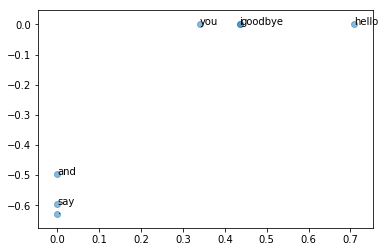

In [9]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id,0], U[word_id,1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()